In [1]:
%matplotlib inline
import os
import glob
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.collector import Collector
from src.learning.training.generator import GenFiles
from src.learning.training.training_file_reader import TrainingFileReader
from notebooks.notebook_commons import read_shifted_numerics_and_targets, read_stored_data_with_shifted_labels, create_memorized_dataset
from src.utilities.transformer import Transformer

In [23]:
def plot_stuff(title, plot_elems, bins=None, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Count')
    
    for plot_elem in plot_elems:
        plt.hist(plot_elem['data'], bins=bins, label=plot_elem['label'], alpha=plot_elem['alpha'])

    plt.grid(axis='both')
    plt.legend(loc='best')
    plt.show()

def downsample_half_max(frames, numerics, diffs, data_column, bin_size=0.01):
    to_del = None
    
    bins = np.arange(-1.0, 1.0, bin_size)
    indices = np.digitize(data_column, bins)
    unique_bins, counts = np.unique(indices, return_counts=True)
    sorted_counts = np.sort(counts)
    
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = int(np.mean(counts) +  (np.max(counts) - np.mean(counts)) // 2)
    
    for unique_bin, count in count_dict.items():
        if count > threshold_count:
            indexes = np.where(indices == unique_bin)[0]
            to_del_indexes = np.random.choice(indexes, count - threshold_count, replace=False)
            
            if to_del is None:
                to_del = to_del_indexes
            else:
                to_del = np.concatenate((to_del, to_del_indexes))
    
    sampled_frames = np.delete(frames, to_del, axis=0)
    sampled_numerics = np.delete(numerics, to_del, axis=0)
    sampled_diffs = np.delete(diffs, to_del, axis=0)
    
    return sampled_frames, sampled_numerics, sampled_diffs


def downsample_half_max_indexes(data_column, bin_size=0.01):
    downsample_multipliers = np.ones(data_column.shape, dtype=int)
    to_del = None
    
    bins = np.arange(-1.0, 1.0, bin_size)
    indices = np.digitize(data_column, bins)
    unique_bins, counts = np.unique(indices, return_counts=True)
    sorted_counts = np.sort(counts)
    
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = int(np.mean(counts) +  (np.max(counts) - np.mean(counts)) // 2)
    
    for unique_bin, count in count_dict.items():
        if count > threshold_count:
            indexes = np.where(indices == unique_bin)[0]
            to_del_indexes = np.random.choice(indexes, count - threshold_count, replace=False)
            
            downsample_multipliers[to_del_indexes] = 0
    
    return downsample_multipliers

def upsampling(data_column, bin_size=0.001):
    upsample_multipliers = np.zeros(data_column.shape, dtype=int)
    bins = np.arange(-1.0, 1.0, bin_size)
    indices = np.digitize(data_column, bins)
    
    unique_bins, counts = np.unique(indices, return_counts=True)
    count_dict = dict(zip(unique_bins, counts))
    max_count = np.max(counts)

    for i in range(0, upsample_multipliers.shape[0]):
        count = count_dict[indices[i]]
        upsample_multipliers[i] = max_count // count
    
    return upsample_multipliers

def upsample_half_max_indexes(data_column, downsampling, bin_size=0.01):
    upsample_multipliers = np.zeros(data_column.shape, dtype=int)
    bins = np.arange(-1.0, 1.0, bin_size)
    indices = np.digitize(data_column, bins)
    
    unique_bins, counts = np.unique(indices, return_counts=True)
    count_dict = dict(zip(unique_bins, counts))
    threshold_count = int(np.mean(counts) +  (np.max(counts) - np.mean(counts)) // 2)
    
    for i in range(0, upsample_multipliers.shape[0]):
        count = count_dict[indices[i]]
        if downsampling[i] is not 0:
            upsample_multipliers[i] = threshold_count // count
    
    return upsample_multipliers

def store_sampling(new_sampling, path, filename):
    if os.path.isfile(path + filename):
        stored_sampling = np.load(path + filename, allow_pickle=True)
        full_sampling = np.concatenate((stored_sampling, new_sampling), axis=0)
    else:
        full_sampling = new_sampling
        
    np.save(path + filename, full_sampling)

In [22]:
config_manager = ConfigurationManager()
config = config_manager.config

reader = TrainingFileReader(path_to_training='../../training/laps/')
transformer = Transformer(config)
collector = Collector()

filenames = ['lap_1_2020_01_24', 'lap_2_2020_01_24', 'lap_3_2020_01_24', 'lap_4_2020_01_24', 
             'lap_5_2020_01_24', 'lap_6_2020_01_24', 'lap_7_2020_01_24', 'lap_8_2020_02_07', 
             'lap_9_2020_02_07', 'lap_10_2020_02_07', 'lap_11_2020_02_07', 'lap_12_2020_02_10', 
             'lap_13_2020_02_10', 'lap_14_2020_02_10']
#filenames = ['lap_1_2020_01_24', 'lap_2_2020_01_24', 'lap_9_2020_02_07', 'lap_10_2020_02_07', 
#             'lap_11_2020_02_07', 'lap_12_2020_02_10', 'lap_13_2020_02_10', 'lap_14_2020_02_10']
memory_variants = [(1, 1), (4, 1), (4, 4)]
memory_variants = [(4, 1)]

base_path = '../../training/'

In [ ]:
# NB this is shifted steering specific, resized to small resolution

for memory in tqdm(memory_variants):
    memory_string = 'n{}_m{}'.format(*memory)
    path = base_path + memory_string + '/'

    if not os.path.isdir(path):
        os.mkdir(path)
    
    old_genfiles = glob.glob(path + '*')
    for old_genfile in old_genfiles:
        os.remove(old_genfile)
    
    tqdm.write('Writing n{}_m{} files.'.format(*memory))    

    for filename in tqdm(filenames): 
        existing_count = len([fn for fn in os.listdir(path) if fn.startswith('frame_')])

        frames, numerics, diffs = read_stored_data_with_shifted_labels(reader, transformer.resize_and_normalize_video_shifted, filename, collector.numeric_columns(), collector.numeric_columns())
        mem_frames, mem_numerics, mem_diffs = create_memorized_dataset(frames, numerics, diffs, *memory)
        mem_frames, mem_numerics, mem_diffs = downsample_half_max(mem_frames, mem_numerics, mem_diffs, mem_diffs[:, 1])
        
        for i in range(0, mem_frames.shape[0]):
            np.save(path + GenFiles.frame.format(memory_string, i + existing_count), mem_frames[i])
            np.save(path + GenFiles.steer.format(memory_string, i + existing_count), mem_numerics[i])
            np.save(path + GenFiles.steer_diff.format(memory_string, i + existing_count), mem_diffs[i])
    
        steer_diffs_upsampling = upsampling(mem_diffs[:, 1])
        store_sampling(steer_diffs_upsampling, path, GenFiles.steer_sampling.format(memory_string))

        gc.collect()
    tqdm.write('kinda done')

In [ ]:
a = np.random.rand(5)
b = np.array([0, 0, 1, 1, 2])
np.repeat(a, b)

In [24]:
# NB this is shifted steering specific, cut half wide frames

for memory in tqdm(memory_variants):
    memory_string = 'n{}_m{}'.format(*memory)
    path = base_path + memory_string + '/'

    if not os.path.isdir(path):
        os.mkdir(path)
    
    old_genfiles = glob.glob(path + '*')
    for old_genfile in old_genfiles:
        os.remove(old_genfile)
    
    tqdm.write('Writing n{}_m{} files.'.format(*memory))    
    
    mem_slice_frames = []
    mem_slice_numerics = []
    
    for filename in tqdm(filenames): 
        existing_count = len([fn for fn in os.listdir(path) if fn.startswith('frame_')])
        
        numerics, diffs = read_shifted_numerics_and_targets(reader, filename, collector.numeric_columns(), collector.numeric_columns())
        stored_i = 0
        
        for i, frame in reader.read_video_gen(filename + '.avi', diffs.shape[0]):
            mem_frame = transformer.session_frame_wide(frame, mem_slice_frames)
            mem_numeric = transformer.session_numeric_np(numerics[i], mem_slice_numerics)
            
            if mem_frame is None or mem_numeric is None:
                continue
            
            np.save(path + GenFiles.frame.format(memory_string, stored_i + existing_count), mem_frame)
            np.save(path + GenFiles.steer.format(memory_string, stored_i + existing_count), mem_numeric)
            np.save(path + GenFiles.steer_diff.format(memory_string, stored_i + existing_count), diffs[i])
            stored_i += 1
        gc.collect()
        
        downsampling = downsample_half_max_indexes(diffs[:, 1])
        upsampling = upsample_half_max_indexes(diffs[:, 1], downsampling)
        store_sampling(upsampling, path, GenFiles.steer_sampling.format(memory_string))
        break
    
    tqdm.write('kinda done')

Writing n4_m1 files.


kinda done



In [25]:
samp_diffs = np.repeat(diffs, upsampling, axis=0)

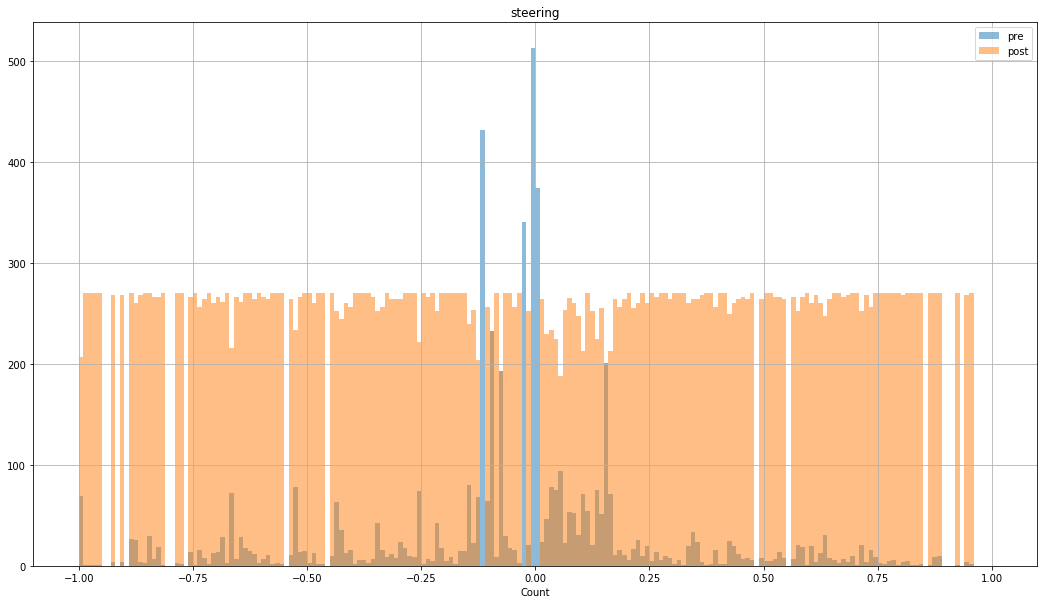

In [26]:
plot_elems = []
plot_elems.append({'data': diffs[:, 1], 'label': 'pre', 'alpha': 0.5})
plot_elems.append({'data': samp_diffs[:, 1], 'label': 'post', 'alpha': 0.5})
bins = np.arange(-1.0, 1.01, 0.01)

plot_stuff('steering', plot_elems, bins)